In [2]:
def get_unique_values(keys, target_key, datatype = float):
    unique_c_values = set()  

    for key in keys:
        if not (target_key + "=") in key:
            continue
        key_value_pairs = key.split(", ")
        for pair in key_value_pairs:
            k, v = pair.split("=") 
            if k == target_key:
                unique_c_values.add(datatype(v))

    unique_c_values_list = sorted(list(unique_c_values))

    return unique_c_values_list

def get_param_value(filename, target_key, value_type = float):
    unique_c_values = set()

    l = filename.split("_")
    
    tmp = l[l.index(target_key) + 1]
    if ".json" in tmp:
        val = value_type(tmp[:-5])
    else:
        val = value_type(tmp)

    return val

In [5]:
import json, glob
gate_type = "haar"
error_type = "depol"

n_data = 50
eps = 1e-4
load_each_J = True
load_each_c = True

assert load_each_J and load_each_c, "both required here"

sname = f"../results/success_rate/success_rate_{gate_type}_{error_type}_ndata_*_eps_{eps:.2e}*.json"
fname_list = glob.glob(sname)
#print(fname_list)
ndata_candidates = [get_param_value(_f, "ndata", int) for _f in fname_list]
print("\ncandidates for ndata:")
print(sorted(set(list(ndata_candidates))))
print(f"your choice: {n_data}")

sname = f"../results/success_rate/success_rate_{gate_type}_{error_type}_ndata_{n_data}_cfilled_eps_{eps:.2e}_J_*.json"
fname_list = [f for f in glob.glob(sname) if "_c_" in f]
c_list = sorted(list(set([get_param_value(_f, "c", float) for _f in fname_list])))
print(f"{c_list=}")
data = {}
for c in c_list:
    files = [f for f in glob.glob(sname) if f"_c_{c}" in f and f"_J_" in f]
    J_list = [get_param_value(_f, "J", int) for _f in files]
    for J, filename in zip(J_list, files):
        key = f"c={c}, {J=}"
        data[key] = json.load(open(filename, "r"))
    
        nondiag_l1_data = data[key]["nondiag_l1_data"]


candidates for ndata:
[50]
your choice: 50
c_list=[0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0]


In [6]:
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["font.size"] = 10
cmap = get_cmap("Reds")

eps = 1e-4
threshold = 1e-12
J_list_disp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mydata =[]
ymin = 1
for ii, J in enumerate(J_list_disp):
    success = []
    success_std = []
    
    
    for jj, c in enumerate(c_list):
        
        mykey = f"c={c}, {J=}"
        key = f"eps={eps:.2e}, {J=}, c={c}"
    
        try:
            nondiag_l1_data = data[mykey]["nondiag_l1_data"]
            dnorm_data = data[mykey]["dnorm_data"]
            arr = [_nondiag_l1 <= min([threshold, eps**2 * c]) and _dnorm/2 <= eps**2 * ((c+1)**2) for (_nondiag_l1, _dnorm) in zip(nondiag_l1_data[key], dnorm_data[key])]
            rate = np.mean(arr)
            std = np.std(arr) / np.sqrt(len(arr)-1)

            success.append(rate)
            success_std.append(std)     
        except Exception as e:
            print(e)
            success.append(np.NaN)
            success_std.append(np.NaN)     
            
    mydata.append(success)

/var/folders/xw/hgtg8nx922g7smt8_4th3hxc0000gn/T/ipykernel_67618/1893241127.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Reds")


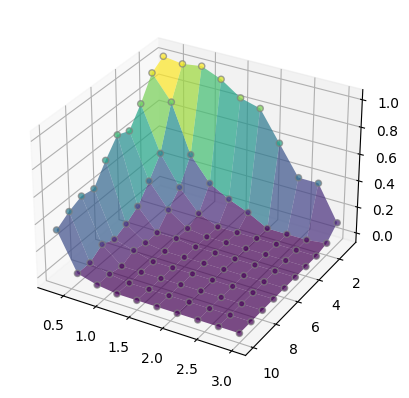

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plot_data = 1-np.array(mydata)
x = c_list
y = J_list_disp

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, plot_data, cmap='viridis', alpha = 0.7)

ax.scatter(X.ravel(), Y.ravel(), plot_data.ravel(), c = plot_data.ravel(), cmap = "viridis", alpha = 0.7, edgecolor = "gray")
ax.invert_yaxis()